## Initialization

### Import

In [21]:
import os
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import netCDF4 as nc
import numpy as np
import pandas as pd

#
from utils import *

### Constants

In [4]:
ABSOLUTE_PATH_ERA5 = "/work/b08209033/DATA/IndianMonsoon/ERA5"
ABSOLUTE_PATH_TempestExtremes = "/work/b08209033/DATA/IndianMonsoon/TempestExtremes"

### Functions

#### Zonal Wind Shear

In [53]:
def calculate_zonal_wind_shear(filename):
    """
    Calculate the Zonal Wind Shear (ZWS) between two atmospheric regions from a NetCDF dataset.

    This function processes zonal wind data at the 850 hPa pressure level to compute the zonal wind shear
    between defined southern and northern regions. The shear is calculated as the difference in the mean
    zonal wind between these regions.

    Parameters
    ----------
    filename : str
        The name of the NetCDF file containing the zonal wind data. The file should include the following
        variables:
        - 'lon' : Longitudes
        - 'lat' : Latitudes
        - 'plev' : Pressure levels (in Pascals)
        - 'u' : Zonal wind components

    Returns
    -------
    tuple of numpy.ndarray
        zws_raw : numpy.ndarray
            The raw zonal wind shear values computed as the difference between the mean zonal winds of the
            southern and northern regions.
        zws_smoothed : numpy.ndarray
            The smoothed zonal wind shear obtained by applying a moving average to the raw ZWS.
        zws_smoothed_grad : numpy.ndarray
            The gradient of the smoothed zonal wind shear, representing the rate of change of ZWS over time.

    Notes
    -----
    - The function assumes that the data spans 43 years with 365 days each year.
    - External helper functions `moving_average` and `split_dimension` are used for smoothing and reshaping
      the data, respectively. Ensure these functions are defined and accessible in the scope.
    - The latitude and longitude ranges for the southern and northern regions are predefined:
        - Southern Region:
            - Latitude: 5°N to 15°N
            - Longitude: 40°E to 80°E
        - Northern Region:
            - Latitude: 20°N to 30°N
            - Longitude: 70°E to 90°E
    """
    # Load dataset and extract dimensions
    filepath = os.path.join(ABSOLUTE_PATH_ERA5, filename)
    dataset = nc.Dataset(filepath)
    longitudes = dataset["lon"][:]
    latitudes = dataset["lat"][:]
    pressure_levels = dataset["plev"][:] / 100

    # Find the index of the 850 hPa pressure level
    plevel_850 = np.where(np.abs(pressure_levels - 850) < 1e0)[0][0]
    zonal_wind = dataset["u"][:, plevel_850, :, :]

    # Define southern and northern regions
    southern_lat_mask = (latitudes > 5) & (latitudes < 15)
    southern_lon_mask = (longitudes > 40) & (longitudes < 80)
    northern_lat_mask = (latitudes > 20) & (latitudes < 30)
    northern_lon_mask = (longitudes > 70) & (longitudes < 90)

    # Define regions for the ZWS calculation (southern and northern)
    zonal_wind_south = zonal_wind[:, southern_lat_mask, :][:, :, southern_lon_mask]
    zonal_wind_north = zonal_wind[:, northern_lat_mask, :][:, :, northern_lon_mask]

    # Compute mean zonal wind for each region
    mean_wind_south = zonal_wind_south.mean(axis=(1, 2))
    mean_wind_north = zonal_wind_north.mean(axis=(1, 2))

    # Calculate raw zonal wind shear
    zws_raw = mean_wind_south - mean_wind_north

    # Apply moving average to smooth the ZWS
    zws_smoothed = moving_average(zws_raw, axis=0)

    # Calculate the gradient of the smoothed ZWS
    zws_smoothed_grad = np.gradient(zws_smoothed)

    # Reshape arrays to group by year (365 days per year assumed)
    factors = (43, 365)  # (years, days)
    zws_raw = split_dimension(zws_raw, axis=0, factors=factors)
    zws_smoothed = split_dimension(zws_smoothed, axis=0, factors=factors)
    zws_smoothed_grad = split_dimension(zws_smoothed_grad, axis=0, factors=factors)

    return zws_raw, zws_smoothed, zws_smoothed_grad

#### Low Pressure Detection

In [54]:
def calculate_occurrence(filename):
    """
    Calculate the Occurrence of Possible Low-Pressure Systems and Their Smoothed Counts.

    This function processes a tab-separated CSV file containing data on possible low-pressure systems
    (isolated occurrences) for each timestep. It computes both the raw occurrence counts and a smoothed
    version using a moving average.

    Parameters
    ----------
    filename : str
        The name of the CSV file containing low-pressure system occurrence data. The file is expected to
        reside in the directory specified by `ABSOLUTE_PATH_TempestExtremes` and should have the following columns:
            - Year
            - Month
            - Day
            - Occurrence
            - Time

    Returns
    -------
    tuple
        A tuple containing:
            - df : pandas.DataFrame
                The DataFrame containing the raw data with assigned column names.
            - occurrence_raw : numpy.ndarray
                A NumPy array of raw occurrence counts for each timestep.
            - occurrence_smoothed : numpy.ndarray
                A NumPy array of smoothed occurrence counts obtained by applying a moving average
                to the raw data.

    Notes
    -----
    - The function assumes that the dataset spans 43 years with 365 days each year.
    - External helper functions `moving_average` and `split_dimension` are used for smoothing and reshaping
      the data, respectively. Ensure these functions are defined and accessible in the scope.
    """
    # Read the CSV file into a DataFrame, skipping bad lines
    df = pd.read_csv(
        os.path.join(ABSOLUTE_PATH_TempestExtremes, filename),
        sep="\t",
        on_bad_lines="skip",
        header=None,
    )

    # Assign meaningful column names
    df.columns = ["Year", "Month", "Day", "Occurrence", "Time"]
    df = df.astype(int)

    # Extract occurrence data and compute the moving average
    occurrence_raw = df["Occurrence"].to_numpy()
    occurrence_smoothed = moving_average(occurrence_raw, axis=0)

    # Reshape the raw and smoothed occurrence data to group by year (assuming 365 days per year)
    factors = (43, 365)  # (years, days)
    occurrence_raw = split_dimension(occurrence_raw, axis=0, factors=factors)
    occurrence_smoothed = split_dimension(occurrence_smoothed, axis=0, factors=factors)

    return df, occurrence_raw, occurrence_smoothed

#### Streamfunction

In [55]:
def calculate_streamfunction(filename):
    """
    Calculate the mass streamfunction on the Y-Z Plane by integrating meridional divergent wind.

    This function computes the streamfunction by integrating the mean divergent meridional wind over
    pressure levels and applying appropriate weighting based on latitude.

    Parameters
    ----------
    filename : str
        The name of the NetCDF file containing the necessary atmospheric data. The file should include the
        following variables:
            - 'plev' : Pressure levels (in Pascals)
            - 'lon' : Longitudes (in degrees)
            - 'lat' : Latitudes (in degrees)
            - 'v' : Divergent meridional wind components

    Returns
    -------
    tuple
        A tuple containing:
            - streamfunction : numpy.ndarray
                The computed mass streamfunction organized by year and day.
            - streamfunction_smoothed : numpy.ndarray
                The smoothed mass streamfunction obtained by applying a moving average to the raw streamfunction.
            - (pressure_levels, latitudes) : tuple of numpy.ndarray
                A tuple containing the pressure levels (in hectoPascals) and latitudes (in degrees) used in the calculation.

    Notes
    -----
    - **Assumptions**:
        - The dataset spans 43 years with 365 days each year.
        - Pressure levels are provided in descending order (from surface to upper atmosphere).
    - **Dependencies**:
        - External helper functions `moving_average` and `split_dimension` are used for smoothing and reshaping
          the data, respectively. Ensure these functions are defined and accessible in the scope.
    - **Data Processing**:
        - The divergent meridional wind ('v') is assumed to be a 4D variable with dimensions corresponding to
          time, pressure level, latitude, and longitude.
        - Pressure thickness is calculated between consecutive pressure levels for integration.
        - The mean divergent meridional wind is averaged over the longitude dimension before integration.
    - **Physical Constants**:
        - `EARTH_RADIUS_METERS` and `EARTH_GRAVITY_ACCELERATION` should be defined in the codebase as they are
          essential for calculating the weighting factors.
    """
    # Load dataset and extract variables
    filepath = os.path.join(ABSOLUTE_PATH_ERA5, filename)
    data = nc.Dataset(filepath)
    pressure_levels = data["plev"][::-1]
    longitudes = data["lon"][:]
    latitudes = data["lat"][:]
    divergent_meridional_wind = data["v"][:, ::-1, :, :]

    # Compute pressure thickness between layers
    pressure_thickness = np.diff(np.insert(pressure_levels, 0, 0))

    # Calculate the mean divergent meridional wind
    mean_divergent_wind = np.mean(divergent_meridional_wind, axis=-1)
    padded_mean_divergent_wind = np.insert(mean_divergent_wind, 0, 0, axis=1)
    interpolated_mean_wind = (
        padded_mean_divergent_wind[:, :-1, :] + padded_mean_divergent_wind[:, 1:, :]
    ) / 2

    # Compute weighting factor based on latitude
    longitude_extent = np.deg2rad(longitudes[-1] - longitudes[0])
    cosine_weighting = np.cos(np.deg2rad(latitudes))
    weighting_factor = (
        longitude_extent
        * EARTH_RADIUS_METERS
        * cosine_weighting
        / EARTH_GRAVITY_ACCELERATION
    )
    # Calculate streamfunction by integrating wind and applying thickness
    streamfunction = np.swapaxes(interpolated_mean_wind, 1, -1) * pressure_thickness
    streamfunction = np.cumsum(streamfunction, axis=-1)
    streamfunction = np.swapaxes(streamfunction, -1, 1) * weighting_factor

    # Apply moving average for smoothing
    streamfunction_smoothed = moving_average(streamfunction, axis=0)

    # Reshape for yearly organization (assuming 365 days per year)
    factors = (43, 365)  # (years, days)
    streamfunction = split_dimension(streamfunction, axis=0, factors=factors)
    streamfunction_smoothed = split_dimension(
        streamfunction_smoothed, axis=0, factors=factors
    )

    return (
        streamfunction,
        streamfunction_smoothed,
        (pressure_levels / 100, latitudes),
    )

#### Equivalent potential temperature

In [57]:
def calculate_equiv_theta(filename):
    """
    Calculate the (smoothed) equivalent potential temperature on the Y-Z Plane.

    This function computes the zonal mean (average over all longitudes) of the
    equivalent potential temperature from a NetCDF dataset. Additionally, it applies
    a moving average to smooth the zonal mean data.

    Parameters
    ----------
    filename : str
        The name of the NetCDF file containing the equivalent potential temperature data. The file is expected
        to reside in the directory specified by `ABSOLUTE_PATH_ERA5` and should include the following variables:
            - 'lon' : Longitudes (in degrees)
            - 'lat' : Latitudes (in degrees)
            - 'plev' : Pressure levels (in Pascals)
            - 'equiv_theta' : Equivalent potential temperature (in Kelvin)

    Returns
    -------
    tuple
        A tuple containing:
            - equivalent_potential_temperature : numpy.ndarray
                The raw zonal mean equivalent potential temperature organized by year and day. Shape:
                (years, days, pressure_levels, latitudes)
            - equivalent_potential_temperature_smoothed : numpy.ndarray
                The smoothed zonal mean equivalent potential temperature obtained by applying a moving average
                to the raw data. Shape:
                (years, days, pressure_levels, latitudes)
            - (pressure_levels, latitudes) : tuple of numpy.ndarray
                A tuple containing the pressure levels (in hectoPascals) and latitudes (in degrees) used in the calculation.

    Notes
    -----
    - **Assumptions**:
        - The dataset spans 43 years with 365 days each year.
        - The 'equiv_theta' variable is a 4D array with dimensions corresponding to time, pressure level, latitude, and longitude.
    - **Dependencies**:
        - External helper functions `moving_average` and `split_dimension` are used for smoothing and reshaping
          the data, respectively. Ensure these functions are defined and accessible in the scope.
    - **Data Processing**:
        - The zonal mean is calculated by averaging the equivalent potential temperature over the longitude dimension.
        - A moving average is applied along the time axis (axis=0) to smooth the zonal mean data.
    """
    filepath = os.path.join(ABSOLUTE_PATH_ERA5, filename)
    data = nc.Dataset(filepath)

    longitudes = data["lon"][:]
    latitudes = data["lat"][:]
    pressure_levels = data["plev"][:] / 100
    equivalent_potential_temperature = data["equiv_theta"][:]

    # Compute the zonal mean of theta (average over longitude)
    equivalent_potential_temperature = np.mean(equivalent_potential_temperature, axis=3)

    # Apply moving average to smooth the zonal mean
    equivalent_potential_temperature_smoothed = moving_average(
        equivalent_potential_temperature, axis=0
    )

    # Reshape the data to organize by year and day (assuming 365 days per year)
    factors = (43, 365)  # (years, days)
    equivalent_potential_temperature = split_dimension(
        equivalent_potential_temperature, axis=0, factors=factors
    )
    equivalent_potential_temperature_smoothed = split_dimension(
        equivalent_potential_temperature_smoothed, axis=0, factors=factors
    )

    return (
        equivalent_potential_temperature,
        equivalent_potential_temperature_smoothed,
        (pressure_levels, latitudes),
    )

#### MSE (Moist Static Energy) flux

In [58]:
def calculate_MSE_vertical_flux(mse_filename, w_filename):
    """
    Calculate the Moist Static Energy (MSE) vertical flux.

    This function computes the vertical flux of Moist Static Energy by multiplying
    the MSE with the vertical wind component. It then calculates the zonal mean,
    applies a moving average for smoothing, and reshapes the data by year and day.

    Parameters
    ----------
    mse_filename : str
        Name of the NetCDF file containing Moist Static Energy data.
    w_filename : str
        Name of the NetCDF file containing vertical wind component data.

    Returns
    -------
    tuple
        mse_vertical_flux : numpy.ndarray
            Zonal mean MSE vertical flux organized by year and day.
        mse_vertical_flux_smoothed : numpy.ndarray
            Smoothed zonal mean MSE vertical flux.
        tuple of numpy.ndarray
            (pressure_levels, latitudes)

    Notes
    -----
    - Assumes data spans 43 years with 365 days each year.
    - Utilizes helper functions `moving_average` and `split_dimension`.
    """
    # Construct full file paths
    mse_filepath = os.path.join(ABSOLUTE_PATH_ERA5, mse_filename)
    w_filepath = os.path.join(ABSOLUTE_PATH_ERA5, w_filename)

    # Load datasets using context managers to ensure they are closed after processing
    with nc.Dataset(mse_filepath) as mse_data, nc.Dataset(w_filepath) as w_data:
        longitudes = mse_data["lon"][:]
        latitudes = mse_data["lat"][:]
        pressure_levels = mse_data["plev"][:]

        moist_static_energy = mse_data["MSE"][:]  # Shape: (time, pressure, lat, lon)

        # Align vertical wind with MSE pressure levels
        pressure_mask = np.isin(w_data["plev"][:], pressure_levels)
        vertical_wind = w_data["w"][:, pressure_mask, :, :]  # Aligned shape

    # Compute MSE vertical flux
    mse_vertical_flux = moist_static_energy * vertical_wind

    # Calculate zonal mean (average over longitude axis, assumed to be axis=3)
    mse_vertical_flux = np.mean(mse_vertical_flux, axis=3)

    # Apply moving average for smoothing along the time axis
    mse_vertical_flux_smoothed = moving_average(mse_vertical_flux, axis=0)

    # Reshape data to organize by year and day (assuming 365 days per year)
    mse_vertical_flux = split_dimension(mse_vertical_flux, axis=0, factors=(43, 365))
    mse_vertical_flux_smoothed = split_dimension(
        mse_vertical_flux_smoothed, axis=0, factors=(43, 365)
    )

    return mse_vertical_flux, mse_vertical_flux_smoothed, (pressure_levels, latitudes)

## Main

### Zonal Wind Shear

In [9]:
# Calculate ZWS and its derived quantities
zws_raw, zws_smoothed, zws_smoothed_grad = calculate_zonal_wind_shear("u.nc")

# Identify the monsoon onset date for each year based on when ZWS becomes positive
years = np.arange(1979, 2022)
onset_days = np.argmax(zws_smoothed > 0, axis=1)
monsoon_onset = dict(zip(years.tolist(), onset_days.tolist()))

# Sort the onset dates in ascending order of the day of the year
monsoon_onset_sorted = dict(sorted(monsoon_onset.items(), key=lambda item: item[1]))

### Occurrence

In [10]:
# Calculate the raw and smoothed occurrence data
_, occurrence_raw, occurrence_smoothed = calculate_occurrence(
    "TropicalCycloneCount_925.csv"
)

### Streamfunction

In [11]:
streamfunction_raw, streamfunction_smoothed, streamfunction_grids = (
    calculate_streamfunction("indian_divergent_uv.nc")
)

### Equivalent potential temperature

In [12]:
equiv_theta_raw, equiv_theta_smoothed, equiv_theta_grids = calculate_equiv_theta(
    "indian_equiv_theta.nc"
)

In [9]:
filepath = os.path.join(ABSOLUTE_PATH_ERA5, "indian_equiv_theta.nc")
data = nc.Dataset(filepath)
times = data["time"][:]
longitudes = data["lon"][:]
latitudes = data["lat"][:]
pressure_levels = data["plev"][:] / 100

segment_day = 96

In [10]:
equivalent_potential_temperature = data["equiv_theta"][
    :, 0, :, :
]  # (time, pressure, latitude, longitude)
equiv_theta_fullgrids = (times, latitudes, longitudes)
# Symmetric and antisymmetric decomposition
(
    equivalent_potential_temperature_symmetric,
    equivalent_potential_temperature_antisymmetric,
) = decompose_symmetric_antisymmetric(equivalent_potential_temperature, axis=1)

# Compute PSD for symmetric, antisymmetric, and total
psd_symmetric, spectral_grid = compute_segmented_PSD(
    equivalent_potential_temperature_symmetric, equiv_theta_fullgrids
)
psd_antisymmetric, spectral_grid = compute_segmented_PSD(
    equivalent_potential_temperature_antisymmetric, equiv_theta_fullgrids
)
psd_total = psd_symmetric + psd_antisymmetric

# Apply filtering to obtain background PSD
background_psd = apply_121_filter(
    apply_121_filter(psd_total / 2, axis=1, iterations=10), axis=0, iterations=10
)

# Dimensionalize frequency
# From nondimensional ordinary wavenumber to ordinary wavenumber
# (cycles) -->  (cycles/day))
spectral_grid = (spectral_grid[0] / segment_day, spectral_grid[1])

In [22]:
def plot_spectral_contour(
    PSD_data,
    spectral_grid,
    wavenumber_range,
    title,
    xlabel,
    ylabel,
    log_value=True,
):
    """Helper function to plot a spectral contour with filled levels and contours."""
    wavenumbers, positive_frequencies = spectral_grid[1], spectral_grid[0]
    plt.rcParams.update({"font.size": 22})

    plt.figure(figsize=(16, 9), dpi=160)

    wavenum_indices = slice(
        np.argmax(wavenumbers >= wavenumber_range[0]),
        np.argmax(wavenumbers >= wavenumber_range[1]) + 1,
    )
    if log_value:
        plt.contourf(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            np.log10(PSD_data[:, wavenum_indices]),
            levels=16,
            cmap="Greys",
        )
        plt.contour(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            np.log10(PSD_data[:, wavenum_indices]),
            levels=32,
            colors="black",
        )
    else:
        plt.contourf(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            PSD_data[:, wavenum_indices],
            levels=16,
            cmap="Greys",
            extend="min",
        )
        plt.contour(
            wavenumbers[wavenum_indices],
            positive_frequencies,
            PSD_data[:, wavenum_indices],
            levels=32,
            colors="black",
        )
    plt.plot([0, 0], [0, positive_frequencies[-1]], "k--", lw=2, zorder=20)
    plt.gca().add_patch(
        Rectangle(
            (wavenumber_range[0], positive_frequencies[0]),
            wavenumber_range[1] - wavenumber_range[0],
            positive_frequencies[1] - positive_frequencies[0],
            edgecolor="white",
            facecolor="white",
            fill=True,
            lw=4,
            zorder=10,
        )
    )

    plt.gca().add_patch(
        Rectangle(
            (wavenumber_range[0], positive_frequencies[-2]),
            wavenumber_range[1] - wavenumber_range[0],
            positive_frequencies[1] - positive_frequencies[0],
            edgecolor="white",
            facecolor="white",
            fill=True,
            lw=4,
            zorder=10,
        )
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


def OLR_PSD_plot(olr_PSD, olr_spectral_grid, type="Undefined"):
    olr_positive_PSD, positive_spectral_grid = extract_positive_PSD(
        olr_PSD, olr_spectral_grid
    )

    plot_spectral_contour(
        olr_positive_PSD,
        positive_spectral_grid,
        wavenumber_range=(-15, 15),
        title=f"OLR {type} Log Power Spectrum",
        xlabel="wavenumbers",
        ylabel="frequencies (cpd)",
    )
    return 0


def OLR_background_PSD_plot(olr_PSD, olr_spectral_grid):
    positive_background_PSD, positive_spectral_grid = extract_positive_PSD(
        olr_PSD, olr_spectral_grid
    )

    plot_spectral_contour(
        positive_background_PSD,
        positive_spectral_grid,
        wavenumber_range=(-15, 15),
        title="OLR Background Log Power Spectrum",
        xlabel="wavenumbers",
        ylabel="frequencies (cpd)",
    )
    return 0


def OLR_PSD_ratio_plot(
    olr_PSD, olr_background_PSD, olr_spectral_grid, type="Undefined"
):
    positive_PSD, positive_spectral_grid = extract_positive_PSD(
        olr_PSD, olr_spectral_grid
    )
    positive_background_PSD, _ = extract_positive_PSD(
        olr_background_PSD, olr_spectral_grid
    )

    PSD_ratio = positive_PSD / positive_background_PSD

    plot_spectral_contour(
        PSD_ratio,
        positive_spectral_grid,
        wavenumber_range=(-15, 15),
        title=f"OLR {type} Power Spectrum Ratio",
        xlabel="wavenumbers",
        ylabel="frequencies (cpd)",
        log_value=False,
    )
    return 0

0

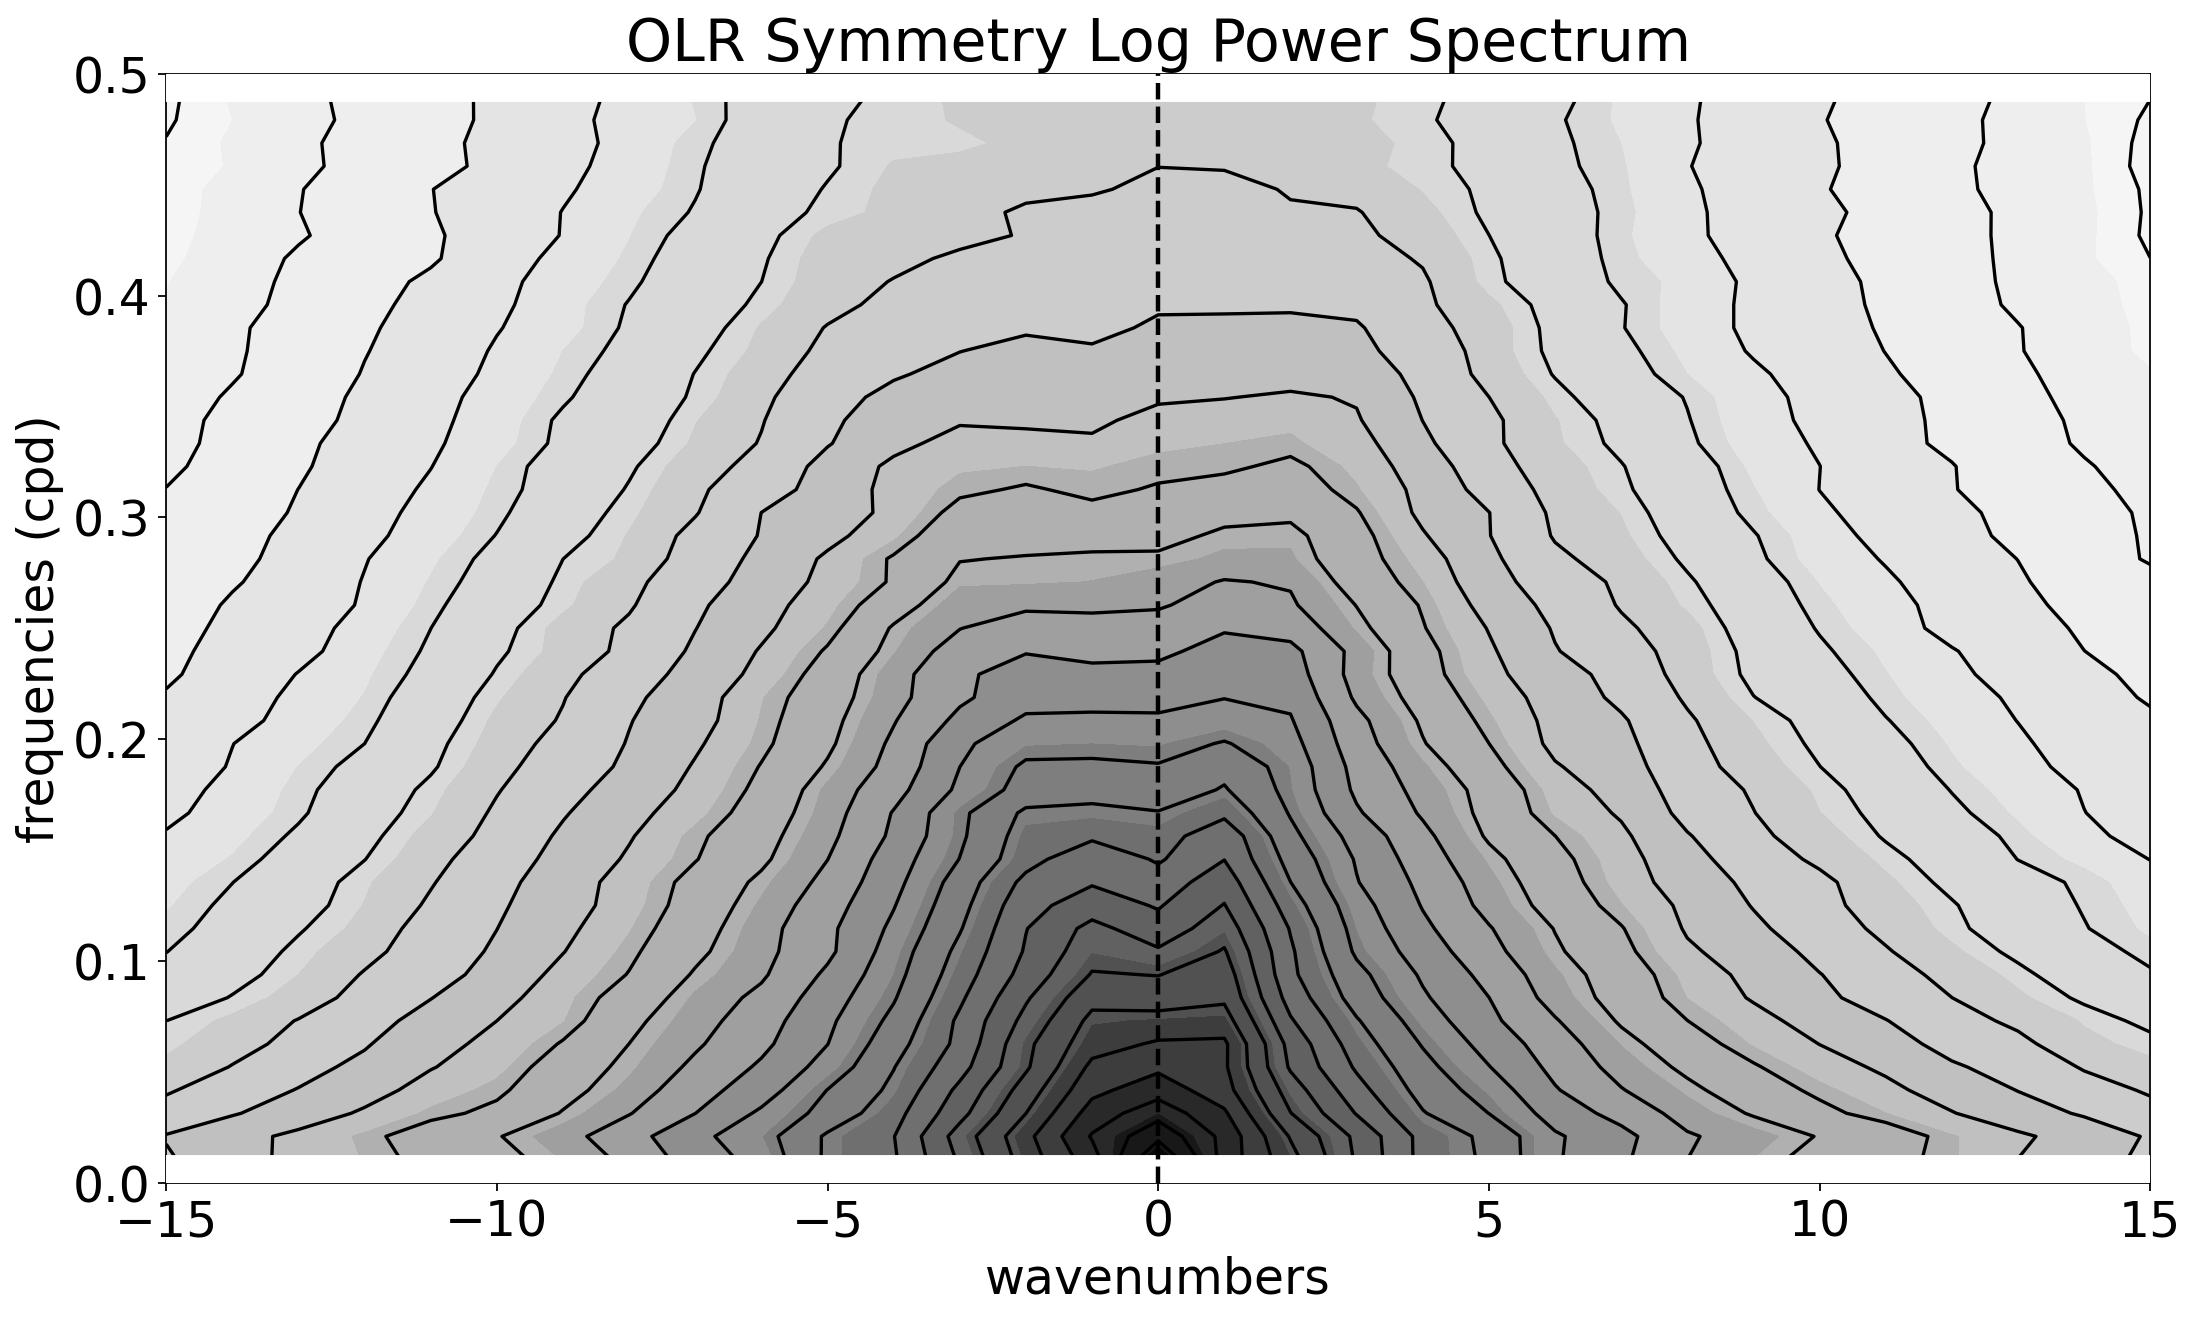

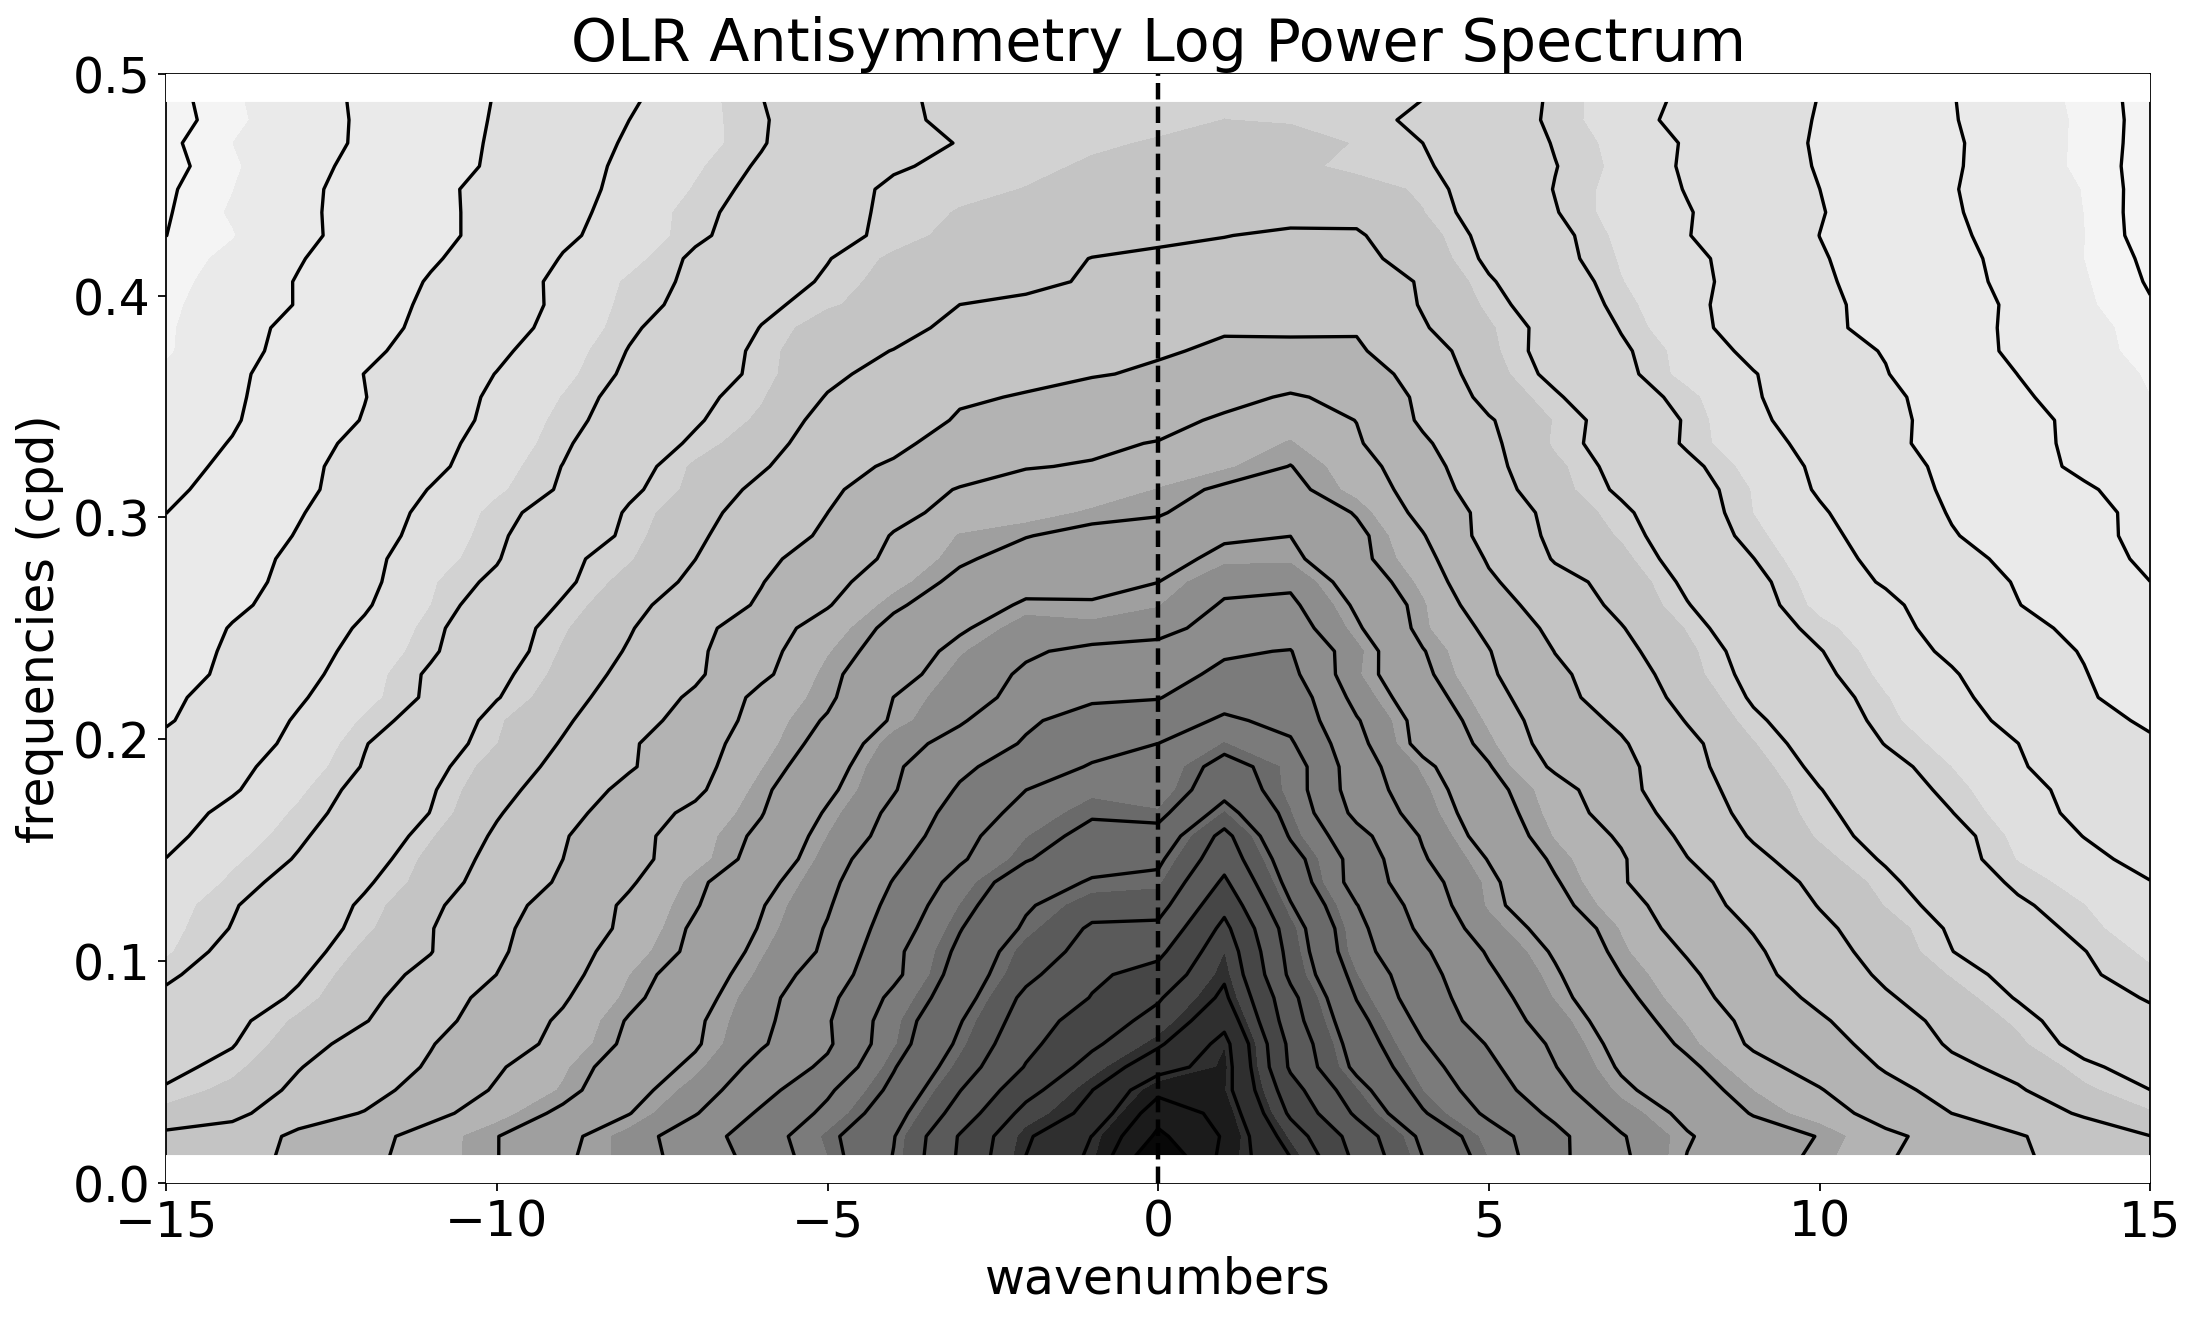

In [23]:
OLR_PSD_plot(psd_symmetric, spectral_grid, type="Symmetry")
OLR_PSD_plot(psd_antisymmetric, spectral_grid, type="Antisymmetry")

### MSE (Moist Static Energy) flux

In [13]:
mse_flux_raw, mse_flux_smoothed, mse_flux_grids = calculate_MSE_vertical_flux(
    "indian_MSE.nc", "indian_w.nc"
)

## Plot

### Code

In [25]:
def display_ZWS_evolution():
    # Disable interactive mode
    plt.ioff()
    # Set figure parameters
    plt.rcParams.update({"font.size": 14})
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), dpi=160, sharex=True)

    # Upper Left: Raw ZWS
    for i in range(43):
        axes[0, 0].plot(zws_raw[i], color="gray", lw=0.6)
    axes[0, 0].plot(np.mean(zws_raw, axis=0), color="red")
    axes[0, 0].plot([0, 365], [0, 0], "k--")
    axes[0, 0].set_ylabel("Speed (m/s)")
    axes[0, 0].set_title("ZWS (Raw)")

    # Upper Right: Smoothed ZWS
    for i in range(43):
        axes[0, 1].plot(zws_smoothed[i], color="gray", lw=0.6)
    axes[0, 1].plot(np.mean(zws_smoothed, axis=0), color="red")
    axes[0, 1].plot([0, 365], [0, 0], "k--")
    axes[0, 1].set_ylabel("Speed (m/s)")
    axes[0, 1].set_title("ZWS (Smoothed)")

    # Lower Left: Gradient of Smoothed ZWS
    for i in range(43):
        axes[1, 0].plot(zws_smoothed_grad[i], color="gray", lw=0.6)
    axes[1, 0].plot(np.mean(zws_smoothed_grad, axis=0), color="blue", lw=1.2)
    axes[1, 0].plot([0, 365], [0, 0], "k--")
    axes[1, 0].set_xlabel("Days since 01/01")
    axes[1, 0].set_ylabel("ZWS Gradient (m/s/day)")
    axes[1, 0].set_title("ZWS Gradient (Smoothed)")

    # Lower Right: Smoothed Occurrence of Low Pressure Systems
    for i in range(43):
        axes[1, 1].plot(occurrence_smoothed[i], color="gray", lw=0.6)
    axes[1, 1].plot(np.mean(occurrence_smoothed, axis=0), color="red", lw=1.2)
    axes[1, 1].set_xlabel("Days since 01/01")
    axes[1, 1].set_ylabel("Occurrence")
    axes[1, 1].set_title("Low Pressure Occurrence (Smoothed)")

    # Add a common title
    fig.suptitle(f"Variable Charts\nRunning Window = {WINDOW_SIZE} (days)")

    return fig

In [ ]:
def display_streamfunction_composites_evolution(
    streamfunction, latitudes, pressure_levels
):
    """
    Generate an animation of streamfunction composites for early and late monsoon onsets.

    This function creates an animation with two subplots:
    - Left: Composite of early monsoon onset years.
    - Right: Composite of late monsoon onset years.

    The composites are averaged over specified years and smoothed using a moving average.

    Parameters
    ----------
    streamfunction : np.ndarray
        Streamfunction data with dimensions (years, days, lat, pressure).
    latitudes : np.ndarray
        Array of latitude values.
    pressure_levels : np.ndarray
        Array of pressure levels in Pascals.

    Returns
    -------
    matplotlib.animation.FuncAnimation
        Animation object for the streamfunction composites.
    """
    # Configure plot aesthetics
    plt.rcParams.update({"font.size": 28})
    figure, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )

    def init_animation():
        """Initialize the animation."""
        return []

    def update_frame(frame_index):
        """Update the animation frame by frame."""
        # Define early and late onset years (assuming monsoon_onset_sorted is predefined)
        early_years = np.array(list(monsoon_onset_sorted.keys())[:5]) - 1979
        late_years = np.array(list(monsoon_onset_sorted.keys())[-5:]) - 1979

        # Calculate composites
        early_composite = np.mean(
            streamfunction[early_years, frame_index + 100], axis=0
        )
        late_composite = np.mean(streamfunction[late_years, frame_index + 100], axis=0)

        # Define contour levels
        contour_levels = np.linspace(-2e10, 2e10, 16)

        # Plot Early Onset Composite
        axes[0].cla()
        axes[0].invert_yaxis()
        axes[0].set_title("Early Onset")
        axes[0].set_ylabel("Pressure (Pa)")
        axes[0].set_xlabel("Latitude")
        cf1 = axes[0].contourf(
            latitudes,
            pressure_levels,
            early_composite,
            levels=contour_levels,
            extend="both",
            cmap="RdBu_r",
        )
        axes[0].contour(
            latitudes,
            pressure_levels,
            early_composite,
            levels=contour_levels,
            colors="k",
        )

        # Plot Late Onset Composite
        axes[1].cla()
        axes[1].set_title("Late Onset")
        axes[1].set_xlabel("Latitude")
        cf2 = axes[1].contourf(
            latitudes,
            pressure_levels,
            late_composite,
            levels=contour_levels,
            extend="both",
            cmap="RdBu_r",
        )
        axes[1].contour(
            latitudes,
            pressure_levels,
            late_composite,
            levels=contour_levels,
            colors="k",
        )

        # Update the figure's super title
        figure.suptitle(f"Streamfunction\nCalendar Date = {frame_index + 100}")
        plt.tight_layout()

        return []

    # Create the animation
    animation_obj = animation.FuncAnimation(
        figure,
        update_frame,
        frames=70,
        interval=100,
        init_func=init_animation,
    )

    return animation_obj

In [ ]:
def display_equiv_theta_composites_evolution(equiv_theta, latitudes, pressure_levels):
    """
    Generate an animation of equivalent potential temperature (equiv_theta) composites
    for early and late monsoon onsets.

    This function creates an animation with two subplots:
    - Left: Composite of early monsoon onset years.
    - Right: Composite of late monsoon onset years.

    The composites are averaged over specified years and visualized using contour plots.

    Parameters
    ----------
    equiv_theta : np.ndarray
        Equivalent potential temperature data with dimensions (years, days, lat, pressure).
    latitudes : np.ndarray
        Array of latitude values.
    pressure_levels : np.ndarray
        Array of pressure levels in Pascals.

    Returns
    -------
    matplotlib.animation.FuncAnimation
        Animation object for the equiv_theta composites.
    """
    # Configure plot aesthetics
    plt.rcParams.update({"font.size": 28})
    figure, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )

    def init_animation():
        """Initialize the animation."""
        return []

    def update_frame(frame_index):
        """Update the animation frame by frame."""
        # Define early and late onset years (assuming monsoon_onset_sorted is predefined)
        early_years = np.array(list(monsoon_onset_sorted.keys())[:5]) - 1979
        late_years = np.array(list(monsoon_onset_sorted.keys())[-5:]) - 1979

        # Calculate composites
        early_composite = np.mean(equiv_theta[early_years, frame_index + 100], axis=0)
        late_composite = np.mean(equiv_theta[late_years, frame_index + 100], axis=0)

        # Define contour levels
        contour_levels = np.linspace(320, 350, 16)

        # Plot Early Onset Composite
        axes[0].cla()
        axes[0].invert_yaxis()
        axes[0].set_title("Early Onset")
        axes[0].set_ylabel("Pressure (Pa)")
        axes[0].set_xlabel("Latitude")
        cf1 = axes[0].contourf(
            latitudes,
            pressure_levels,
            early_composite,
            levels=contour_levels,
            extend="both",
            cmap="RdBu_r",
        )
        axes[0].contour(
            latitudes,
            pressure_levels,
            early_composite,
            levels=contour_levels,
            colors="k",
        )

        # Plot Late Onset Composite
        axes[1].cla()
        axes[1].set_title("Late Onset")
        axes[1].set_xlabel("Latitude")
        cf2 = axes[1].contourf(
            latitudes,
            pressure_levels,
            late_composite,
            levels=contour_levels,
            extend="both",
            cmap="RdBu_r",
        )
        axes[1].contour(
            latitudes,
            pressure_levels,
            late_composite,
            levels=contour_levels,
            colors="k",
        )

        # Update the figure's super title
        figure.suptitle(f"Equiv_theta\nCalendar Date = {frame_index + 100}")
        plt.tight_layout()

        return []

    # Create the animation
    animation_obj = animation.FuncAnimation(
        figure,
        update_frame,
        frames=70,
        interval=100,
        init_func=init_animation,
    )

    return animation_obj

In [ ]:
def display_sf_equiv_theta_composite_evolution(
    equiv_theta, streamfunction, theta_grids, stream_grids
):
    """
    Generate an animation of equivalent potential temperature (equiv_theta) and streamfunction composites
    for early monsoon onsets.

    The animation consists of contour plots where:
    - Shaded regions represent the equiv_theta composites.
    - Contour lines represent the streamfunction composites.

    Parameters
    ----------
    equiv_theta : np.ndarray
        Equivalent potential temperature data with dimensions (years, days, lat, pressure).
    streamfunction : np.ndarray
        Streamfunction data with dimensions (years, days, lat, pressure).
    theta_grids : tuple of np.ndarray
        Grids for equiv_theta, typically (pressure_levels, latitudes).
    stream_grids : tuple of np.ndarray
        Grids for streamfunction, typically (pressure_levels, latitudes).
    monsoon_onset_sorted : dict
        Dictionary mapping years to monsoon onset days, sorted by onset date.

    Returns
    -------
    matplotlib.animation.FuncAnimation
        Animation object for the composite plots.
    """
    plt.rcParams.update({"font.size": 28})
    figure, ax = plt.subplots(
        nrows=1, ncols=1, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )

    def init_animation():
        """Initialize the animation."""
        return []

    def update_frame(frame_index):
        """Update the animation for each frame."""
        ax.cla()
        ax.invert_yaxis()

        # Define early onset years (first 5 years)
        early_years = np.array(list(monsoon_onset_sorted.keys())[:5]) - 1979

        # Compute composites for equiv_theta and streamfunction
        theta_composite = np.mean(equiv_theta[early_years, frame_index + 100], axis=0)
        stream_composite = np.mean(
            streamfunction[early_years, frame_index + 100], axis=0
        )

        # Define contour levels
        theta_levels = np.linspace(320, 350, 16)
        stream_levels = np.linspace(-3e10, 3e10, 16)

        # Plot equiv_theta as filled contours
        ax.contourf(
            theta_grids[1],
            theta_grids[0],
            theta_composite,
            levels=theta_levels,
            extend="both",
            cmap="RdBu_r",
        )

        # Overlay streamfunction contours
        ax.contour(
            stream_grids[1],
            stream_grids[0],
            stream_composite,
            levels=stream_levels,
            colors="k",
        )

        # Set labels and title
        ax.set_xlabel("Latitude")
        ax.set_ylabel("Pressure (Pa)")
        figure.suptitle(
            f"Contour - Streamfunction\nShading - Equiv_theta\nCalendar Date = {frame_index + 100}"
        )
        plt.tight_layout()

        return []

    animation_obj = animation.FuncAnimation(
        figure,
        update_frame,
        frames=70,
        interval=100,
        init_func=init_animation,
    )

    return animation_obj

In [ ]:
def display_mse_flux_divergence_composites_evolution(
    mse_flux, latitudes, pressure_levels
):
    """
    Generate an animation of Moist Static Energy (MSE) flux composites for early and late monsoon onsets.

    The animation consists of two subplots:
    - Left: Composite of early monsoon onset years.
    - Right: Composite of late monsoon onset years.

    Parameters
    ----------
    mse_flux : np.ndarray
        MSE flux data with dimensions (years, days, lat, pressure).
    latitudes : np.ndarray
        Array of latitude values.
    pressure_levels : np.ndarray
        Array of pressure levels in Pascals.
    monsoon_onset_sorted : dict
        Dictionary mapping years to monsoon onset days, sorted by onset date.

    Returns
    -------
    matplotlib.animation.FuncAnimation
        Animation object for the MSE flux composites.
    """
    # Configure plot aesthetics
    plt.rcParams.update({"font.size": 28})
    figure, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )

    def init_animation():
        """Initialize the animation."""
        return []

    def update_frame(frame_index):
        """Update the animation frame by frame."""
        # Clear both subplots
        axes[0].cla()
        axes[1].cla()

        # Define early and late onset years (first 5 and last 5)
        early_years = np.array(list(monsoon_onset_sorted.keys())[:5]) - 1979
        late_years = np.array(list(monsoon_onset_sorted.keys())[-5:]) - 1979

        # Compute composites for early and late onset
        early_composite = np.mean(mse_flux[early_years, frame_index + 100], axis=0)
        late_composite = np.mean(mse_flux[late_years, frame_index + 100], axis=0)

        # Define contour levels
        contour_levels = np.linspace(-1, 1, 16)

        # Plot Early Onset Composite
        axes[0].invert_yaxis()
        axes[0].set_title("Early Onset")
        cf1 = axes[0].contourf(
            latitudes,
            pressure_levels,
            early_composite,
            levels=contour_levels,
            extend="both",
            cmap="RdBu_r",
        )
        axes[0].contour(
            latitudes,
            pressure_levels,
            early_composite,
            levels=contour_levels,
            colors="k",
        )
        axes[0].set_xlabel("Latitude")
        axes[0].set_ylabel("Pressure (Pa)")

        # Plot Late Onset Composite
        axes[1].set_title("Late Onset")
        cf2 = axes[1].contourf(
            latitudes,
            pressure_levels,
            late_composite,
            levels=contour_levels,
            extend="both",
            cmap="RdBu_r",
        )
        axes[1].contour(
            latitudes,
            pressure_levels,
            late_composite,
            levels=contour_levels,
            colors="k",
        )
        axes[1].set_xlabel("Latitude")

        # Update the figure's super title
        figure.suptitle(f"Calendar Date = {frame_index + 100}")
        plt.tight_layout()

        return []

    # Create the animation
    animation_obj = animation.FuncAnimation(
        figure,
        update_frame,
        frames=70,
        interval=100,
        init_func=init_animation,
    )

    return animation_obj

In [ ]:
def display_mse_streamfunction_composite_evolution(
    mse_flux, streamfunction, mse_grids, stream_grids
):
    """
    Create an animation of MSE flux and streamfunction composites for early monsoon onsets.

    The animation displays:
    - Shaded regions representing the MSE flux composites.
    - Contour lines representing the streamfunction composites.

    Parameters
    ----------
    mse_flux : np.ndarray
        Moist Static Energy (MSE) flux data with dimensions (years, days, lat, pressure).
    streamfunction : np.ndarray
        Streamfunction data with dimensions (years, days, lat, pressure).
    mse_grids : tuple of np.ndarray
        Grids for MSE flux, typically (pressure_levels, latitudes).
    stream_grids : tuple of np.ndarray
        Grids for streamfunction, typically (pressure_levels, latitudes).
    monsoon_onset_sorted : dict
        Dictionary mapping years to monsoon onset days, sorted by onset date.

    Returns
    -------
    matplotlib.animation.FuncAnimation
        Animation object for the MSE flux and streamfunction composites.
    """
    # Configure plot aesthetics
    plt.rcParams.update({"font.size": 28})
    figure, ax = plt.subplots(
        nrows=1, ncols=1, figsize=(16, 9), dpi=160, sharex=True, sharey=True
    )

    def init_animation():
        """Initialize the animation."""
        return []

    def update_frame(frame_index):
        """Update the animation frame by frame."""
        ax.cla()
        ax.invert_yaxis()

        # Select early onset years (first 5 years)
        early_years = np.array(list(monsoon_onset_sorted.keys())[:5]) - 1979

        # Compute composites for MSE_flux and streamfunction
        mse_flux_composite = np.mean(mse_flux[early_years, frame_index + 100], axis=0)
        streamfunction_composite = np.mean(
            streamfunction[early_years, frame_index + 100], axis=0
        )

        # Define contour levels
        mse_levels = np.linspace(-25000, 25000, 16)
        stream_levels = np.linspace(-3e10, 3e10, 16)

        # Plot MSE_flux as filled contours
        ax.contourf(
            mse_grids[1],  # Latitude
            mse_grids[0],  # Pressure
            mse_flux_composite,
            levels=mse_levels,
            extend="both",
            cmap="RdBu",
        )

        # Overlay streamfunction contours
        ax.contour(
            stream_grids[1],  # Latitude
            stream_grids[0],  # Pressure
            streamfunction_composite,
            levels=stream_levels,
            colors="k",
        )

        # Set labels and title
        ax.set_xlabel("Latitude")
        ax.set_ylabel("Pressure (Pa)")
        figure.suptitle(
            f"Contour - Streamfunction\nShading - MSE Vertical Flux\nCalendar Date = {frame_index + 100}"
        )
        plt.tight_layout()

        return []

    # Create the animation
    animation_obj = animation.FuncAnimation(
        figure,
        update_frame,
        frames=70,
        interval=100,
        init_func=init_animation,
    )

    return animation_obj

### Display

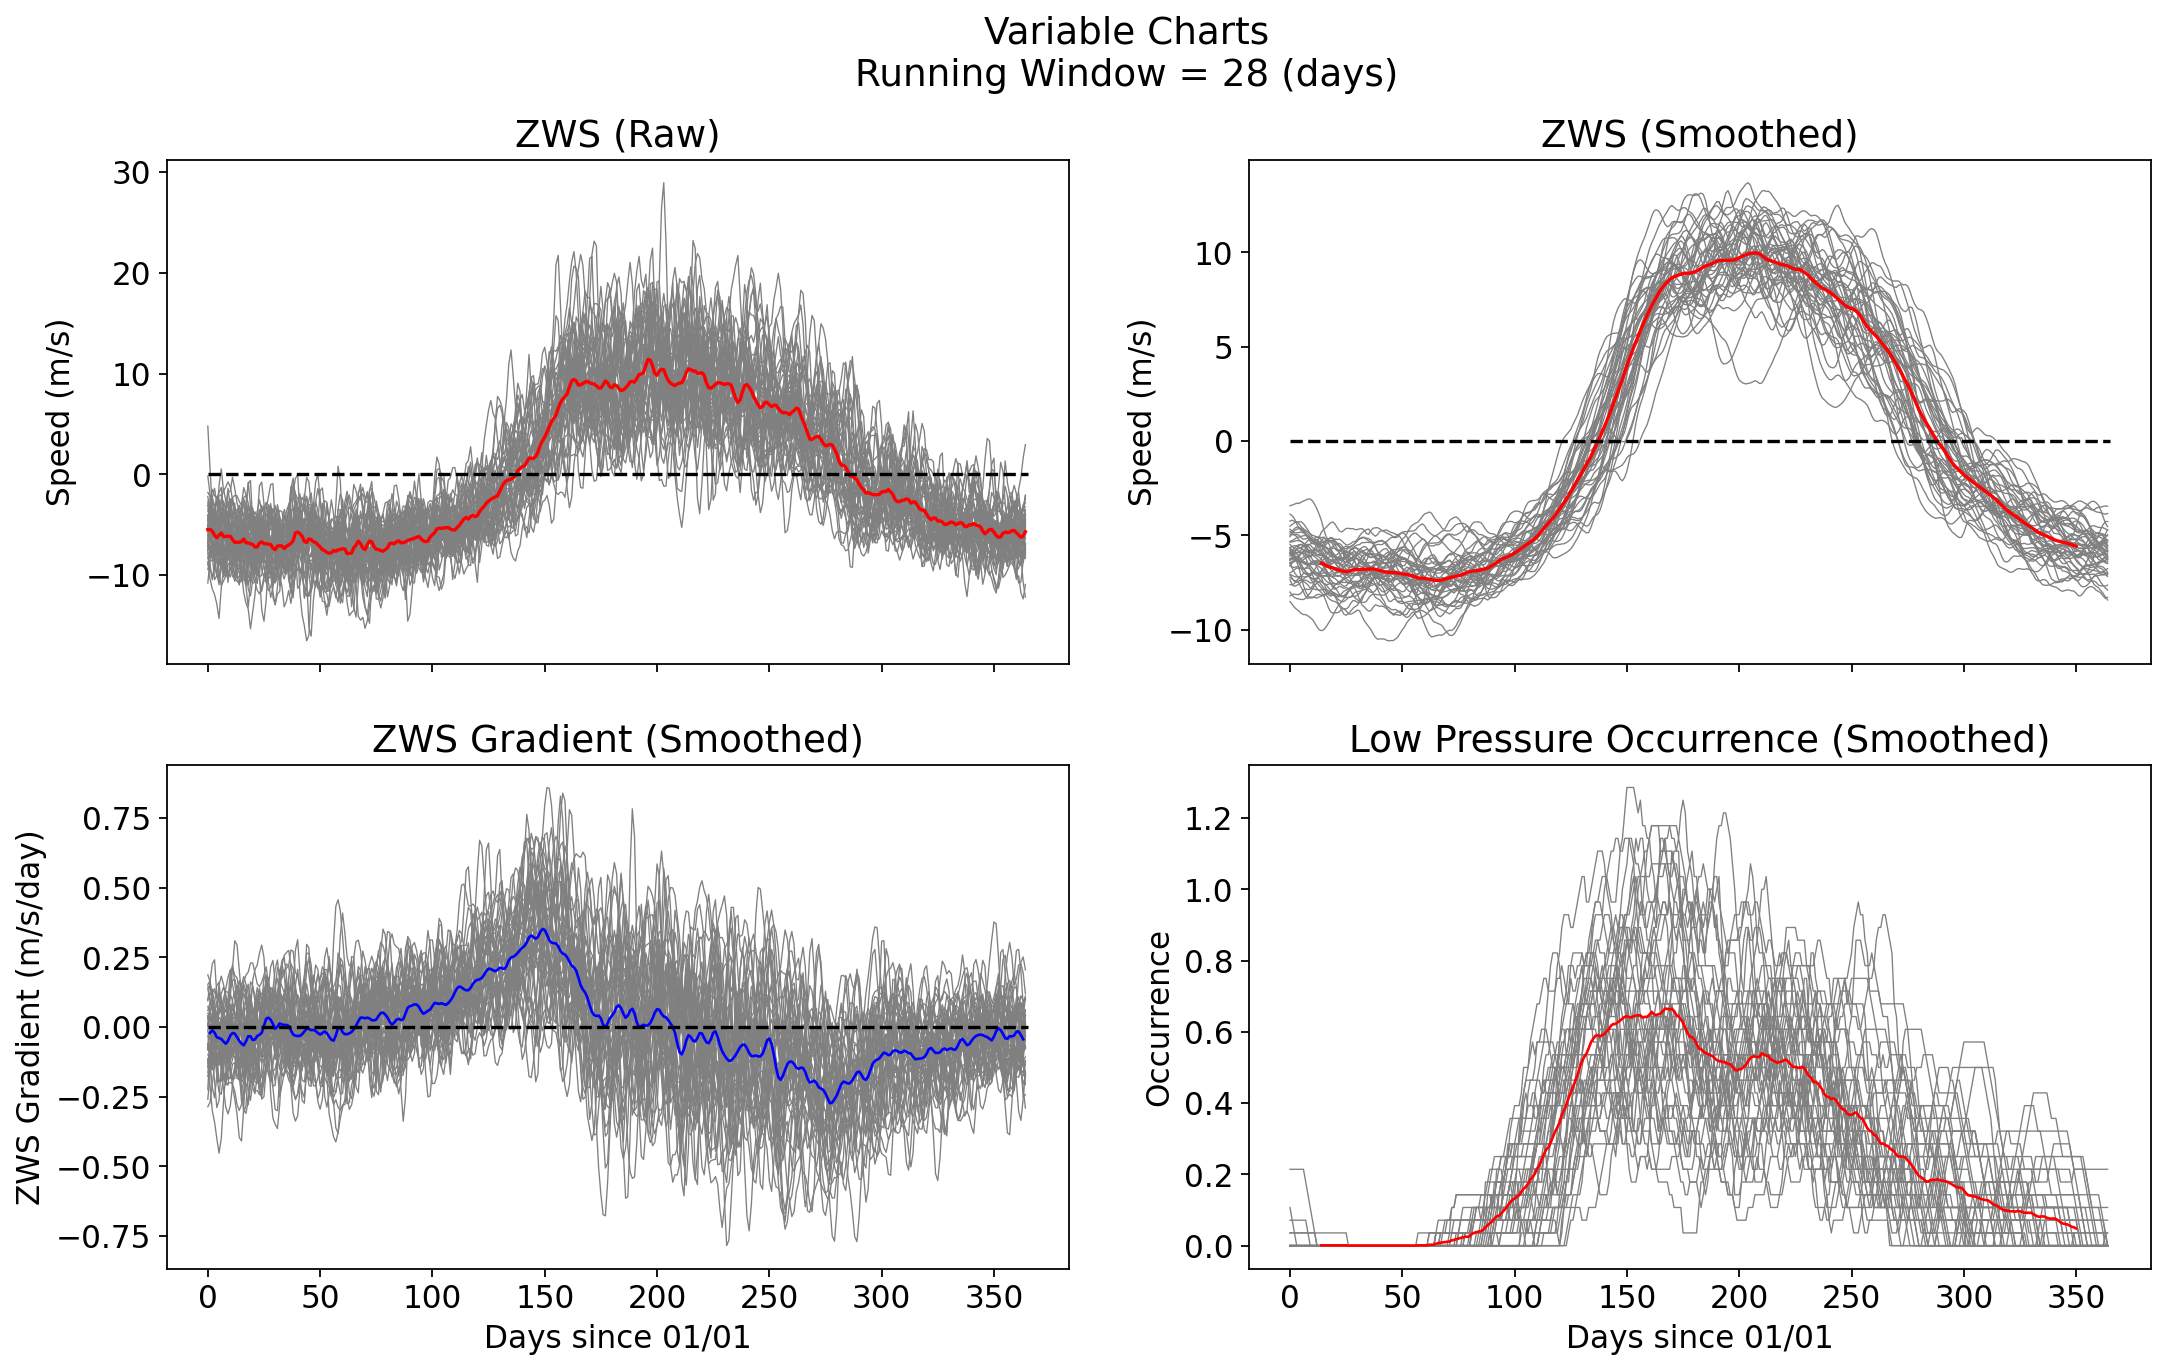

In [29]:
_ = display_ZWS_evolution()
# plt.show()

In [33]:
animation_object = display_streamfunction_composites_evolution(
    streamfunction_smoothed, streamfunction_grids[1], streamfunction_grids[0]
)
# animation_object.save("streamfunction_composites.mp4")

In [36]:
animation_object = display_equiv_theta_composites_evolution(
    equiv_theta_smoothed, equiv_theta_grids[1], equiv_theta_grids[0]
)
# animation_object.save("equiv_theta_composites.mp4")

In [40]:
animation_object = display_sf_equiv_theta_composite_evolution(
    equiv_theta_smoothed,
    streamfunction_smoothed,
    equiv_theta_grids,
    streamfunction_grids,
)
# animation_object.save("equiv_theta_and_streamfunction_composites.mp4")

In [46]:
animation_object = display_mse_flux_divergence_composites_evolution(
    np.gradient(mse_flux_smoothed, mse_flux_grids[0][:], axis=2),
    mse_flux_grids[1],
    mse_flux_grids[0],
)
# animation_object.save("MSE_flux_composites.mp4")

In [50]:
animation_object = display_mse_streamfunction_composite_evolution(
    mse_flux_smoothed,
    streamfunction_smoothed,
    mse_flux_grids,
    streamfunction_grids,
)
# animation_object.save("MSE_flux_and_streamfunction_composites.mp4")